# Introduction
In this Notebook i have done binary classification of Sentiment on a dataset that contains annotated Bangla texts.I have tried to use a deep learning based hybrid network with CNN an LSTM.Through hyper parameter tuning,i have achieved an accuracy of 84% with somewhat overfitting.

My main focus of this notebook is to see the impact of hybrid CNN-BiLSTM model in bangla sentiment analysis and newbie Bangla NLP researchers like me can get a better intution.

# Library & Package Import
I have used KERAS to implement CNN and LSTM in this dataset.

In [265]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Predefined Functions 
I have predefined some functions for the preprocessing of my texts.The dataset contains raw text data that have many unwanted things
(Punctuations,English words,emojis etc..).I have cleaned this things with my function.

In [266]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

# Data Import
The data is in excel file.I have about 6500+ in this dataset.The data is either positive or negative.
I have annotated "0" as Negative and "1" as Positive.

In [267]:
data=pd.read_excel('data/data1.xlsx')
for i in range(2,46):
    d=pd.read_excel('data/data'+str(i)+'.xlsx')
    data=pd.concat([data,d],axis=0,ignore_index=True)

df=data.copy()


In [268]:
df

,Name,Comment,Label
0,মোহাম্মদ সোহেল রানা,খেললো কানাডাজিতলো লেংড়াডা,3.0
1,Preetom Mazumder,"Like I said, World Cup of Goalkeepers",NaN
2,Mizanur Rahman Rupok,Well played Canada 🇨🇦🇨🇦🇨🇦 bed luck..,NaN
3,Mohammed Ahmad,"৫০ধাপ নিচের দল থেকে হারের পর ও যারা চেঁচায়, তা...",3.0
4,Tarek Aziz,কানাডার ভাগ্য খারাপ না হয় বেলজিয়ামের খারাপ খবর...,2.0
...,...,...,...
3596,Sirazul Islam,নেদারল্যান্ড এর সাথে ২ খান খাবে বেশিনা,6.0
3597,Azizur Rahman,ওকে কেউ দাবিয়ে রাখতে পারবেনা।,1.0
3598,Тђє Ғїԍђтєя,খাইয়া দিলেই বাড়ি,6.0
3599,Kaniz Fatema Shimul,ব‍্যাপার না জিতে যাবে আর্জেন্টিনা কিন্তু সেমিত...,1.0


In [269]:
df.drop("Name", inplace=True, axis = 1)

df.dropna(subset=['Label'],inplace=True)

dict = {'Label': 'sentiment', 'Comment':'sentence'}
df.rename(columns=dict,
           inplace=True)
df = df.sample(frac = 1).reset_index(drop=True)


In [270]:
# #df=pd.read_excel('/kaggle/input/pseudolabel/predicted_unsupervised_sentiment.xlsx')
# df=pd.read_excel('/kaggle/input/bengali-news-comments-sentiment/bangla_news_comments_12000.xlsx')
# dict = {'Tag': 'sentiment', 'Comment':'sentence'}
# df.rename(columns=dict,
#           inplace=True)
# df

In [271]:
# df.sentiment = df.sentiment.replace({'Very Negative': -1, 'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Very Positive': 1})

In [272]:
df.sentiment = df.sentiment.replace({4:0, 5:0, 7:1,6:-2,2:0,3:-1 })

In [273]:
df

,sentence,sentiment
0,"হতাশ আমি খুব হতাশ,,,",1.0
1,এটা বুঝতে এতো সময় লাগলো?,0.0
2,আমার ইংল্যান্ড এর খবর কিরে ভাই?,0.0
3,আশরাফুল কে আবার দলে নেওয়া জরুরি।,0.0
4,প্রচুর বিদ্যুৎ অপচয় হচ্ছে 🤩🥴😝,1.0
...,...,...
2675,বাফুফেও তাই ভাবে কিন্তু সালাউদ্দিন সিনিয়র,0.0
2676,এই একটা টিম।যারা '১৮ সালের বিশ্বকাপে হারার পর ...,-2.0
2677,ব্রাজিলের অর্জন বেশি 💗🥀 🇧🇩🇧🇩🇧🇷🇧🇩🇧🇩আর AFA ...,1.0
2678,প্রথম আলোর ছাগলগুলো অতিমাত্রায় গাঁজা খেয়ে মনে ...,-1.0


Now we will visualize the ratio of Postive and Negative sentiment.We can see that the ratio is closly 1:1.Which is considered as a good balance.

e:\Installation\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


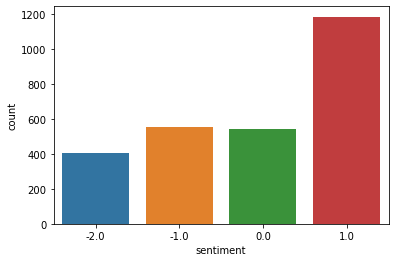

In [274]:
sns.countplot(df['sentiment']);

# Data Preprocessing
At first we will clean the dataset with my predefined function preprocessing().

In [275]:
df['sentence'] = df.sentence.apply(lambda x: preprocessing(str(x)))

In [276]:
df.reset_index(drop=True, inplace=True)

In [277]:
df['sentence']

0                                       হতাশ আমি খুব হতাশ
1                                 এটা বুঝতে এতো সময় লাগলো
2                          আমার ইংল্যান্ড এর খবর কিরে ভাই
3                         আশরাফুল কে আবার দলে নেওয়া জরুরি
4                            প্রচুর বিদ্যুৎ অপচয় হচ্ছে 🤩🥴
                              ...                        
2675            বাফুফেও তাই ভাবে কিন্তু সালাউদ্দিন সিনিয়র
2676    এই একটা টিমযারা  সালের বিশ্বকাপে হারার পর থেকে...
2677      ব্রাজিলের অর্জন বেশি 🥀      আর  দের গর্জন বেশি 
2678    প্রথম আলোর ছাগলগুলো অতিমাত্রায় গাঁজা খেয়ে মনে ...
2679    নাসার এই প্রযুক্তি দিয়ে নেইমারের অপ্রয়োজনীয় গড়...
Name: sentence, Length: 2680, dtype: object

Now I will prepare the dataset to train in the CNN LSTM network.So i have to convert all Sentences into a numpy Array.

I have divided the training and testing data into 80/20 ratio.

I have converted the sentiment values into one hot encodings for the convenient use in model training.


In [278]:
# train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
#split the data into train and test
X=df['sentence']
y=df['sentiment']
#train size 80% and test size 20%
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]
y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

#tfidf vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

training_sentences = []
testing_sentences = []

# merge pair X_train_tfidf and y_train into a dataframe
train1 = pd.DataFrame()
train1['sentence'] = X_train
train1['sentiment'] = y_train
test1 = pd.DataFrame()
test1['sentence'] = X_test
test1['sentiment'] = y_test


train_sentences=train1['sentence'].values
train_labels=train1['sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['sentence'].values
test_labels=test1['sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 2144
Testing Set Length: 536
training_sentences shape: (2144,)
testing_sentences shape: (536,)
train_labels shape: (2144, 2)
test_labels shape: (536, 2)


The Processed result is here what you see:

In [279]:
print(training_sentences[1])
print(train_labels[0])

এটা বুঝতে এতো সময় লাগলো
[0. 1.]


Now i will predefine some variables.

vocab_size is the maximum vocabulary length of Tokenizer.

KERAS tokenzier allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

I will be tokenizing my dataset with this class here.I have did this tokenization so that it can be later used to generate Embeddings.

The main advantage of word embedding is that words that share a similar context can be represented close to each other in the vector space. Thus, vectors carry a sense of semantic of a word.

I have predefined the embedding dimension as 300(embedding_dim).

max_length is the sentence maximum length.

trunc_type is the truncation type.

oov_token is the token for the words that are not present in the corpus.oov means out of vocabulary.

In [280]:
vocab_size = 30000
embedding_dim = 300
max_length = 200
trunc_type='post'
oov_tok = "<OOV>"

In [281]:
print(training_sentences.shape)
print(train_labels.shape)

(2144,)
(2144, 2)


At first i will tokenize and then i will be padding the sequences.I have used tokenizer only on training dataset to see how the model performs on unseen words.

In [282]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)  
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
# padded = sequences


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)
# testing_padded = test_sequences

6789
Word index length:6789


In [283]:
print("Sentence :--> \n")
print(training_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

আমার ইংল্যান্ড এর খবর কিরে ভাই

Sentence Tokenized and Converted into Sequence :--> 

[32, 1104, 43, 134, 1555, 44]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   

In [284]:
# print("Padded shape(training): "+str(padded.shape))
# print("Padded shape(testing): "+str(testing_padded.shape))

# Model Creation
At first i have created embeddings from the text.

In first layer,i created an conv1D with 200 as filter for CNN.

In second & third layer,i have applied two Bi-LSTM with a dropout of .5.

In rest of the layer i have applied Dense network.

I have used Adap Optimizer with fine tuned hyperparameters.

I have also applied L2 regularizations to reduce overfitting as much as possible.

In [285]:
with tf.device('/gpu:0'):
    model= Sequential()       #standard way of building a neural network in Keras and it allows you to stack layers in a linear manner, one after the other
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length)) #embedding layer will output 3D tensor with shape (batch_size, max_length, embedding_dim).
    model.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    # model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 300)          9000000   
                                                                 
 conv1d_12 (Conv1D)          (None, 198, 200)          180200    
                                                                 
 bidirectional_24 (Bidirecti  (None, 198, 128)         135680    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 198, 128)          0         
                                                                 
 bidirectional_25 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_48 (Dense)            (None, 50)              

I trained the model for 5 epochs with batch size 256.

In [286]:

history=model.fit(padded,train_labels,epochs=3,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/3
9/9 [==============================] - 100s 11s/step - loss: 1.3202 - accuracy: 0.6427 - val_loss: 1.2463 - val_accuracy: 0.6698
Epoch 2/3
9/9 [==============================] - 92s 10s/step - loss: 1.2421 - accuracy: 0.6427 - val_loss: 1.1917 - val_accuracy: 0.6698
Epoch 3/3
9/9 [==============================] - 90s 10s/step - loss: 1.1927 - accuracy: 0.6427 - val_loss: 1.1483 - val_accuracy: 0.6698


In [287]:
#change batch size
# history2=model.fit(padded,train_labels,epochs=3,batch_size=512,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)
# history3=model.fit(padded,train_labels,epochs=3,batch_size=1024,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)
# history4=model.fit(padded,train_labels,epochs=3,batch_size=2048,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

#change epochs
# history5=model.fit(padded,train_labels,epochs=5,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)
# history6=model.fit(padded,train_labels,epochs=7,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)
# history7=model.fit(padded,train_labels,epochs=9,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

# Visualization

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


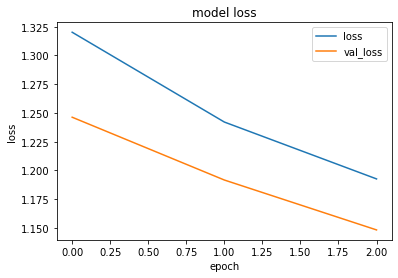

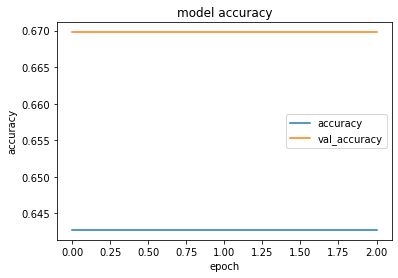

In [288]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

#plot batch size vs validation accuracy
# batch_size=[256,512,1024,2048]
# val_accuracies=[history.history['val_accuracy'],history2.history['val_accuracy'],history3.history['val_accuracy'],history4.history['val_accuracy']]
# plt.plot(batch_size,val_accuracies)
# plt.title('batch size vs validation accuracy')
# plt.ylabel('validation accuracy')
# plt.xlabel('batch size')
# plt.legend(['val_accuracy'])
# plt.show()

In [289]:
# #plot epochs vs validation accuracy
# epochs=[3,5,7,9]
# val_accuracies=[history.history['val_accuracy'][2],history5.history['val_accuracy'][4],history6.history['val_accuracy'][6],history7.history['val_accuracy'][8]]
# plt.plot(epochs,val_accuracies)
# plt.title('epochs vs validation accuracy')
# plt.ylabel('validation accuracy')
# plt.xlabel('epochs')
# plt.legend(['val_accuracy'])
# plt.show()

# Accuracy and Evaluation

In [290]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=256)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=256)
print("The test accuracy is: "+str(loss_and_metrics[1]))

9/9 [==============================] - 17s 2s/step - loss: 1.1668 - accuracy: 0.6427
The train accuracy is: 0.6427238583564758
3/3 [==============================] - 4s 1s/step - loss: 1.1483 - accuracy: 0.6698
The test accuracy is: 0.6697761416435242
